# Udacity Data Analyst Nanodegree
### Project 2 - Investigate a dataset: Titanic Dataset Analysis

## Part 1: Abstract

__The main question this project seeks to answer is:__ What factors were correlated with survival rates on the Titanic?

Python and Pandas were used to analyze a set of passenger data from the Titanic to identify factors that correlate with the survival rate. This project will start by first importing and cleaning the data, then will move to an exploratory phase to find correlations between any factors and survival rates, and lastly, any conclusions about the correlations will be presented.

## Part 2: Data formatting and cleaning

### 2.1 Data import and initial checks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data from the supplied CSV
titanic = pd.read_csv('./titanic_data.csv')

In [3]:
# Check the first few rows of the data to get a feel for what values the columns can contain
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [4]:
# Check to see if there are any missing values in the data
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 2.2 Approach for missing values

The following columns listed below had some issue with the data. Each column is listed with the action that was taken to correct or address the issue. In some cases data was imputed (missing values were substituted with estimated values) and it should be noted that this may have an affect on any computed statistics (e.g. it may bias the variance downward). This was done for ease of data exploration and will be taken into account in analysis if such columns are found to have the high survival correlation we are seeking; it will otherwise be ignored.

__Cabin column:__ Due to the high number of missing values from the Cabin column (77.1%) and no notable correlation to survival, this column will simply be ignored in the analysis.

In [5]:
del titanic['Cabin']

__Embarked column:__ The missing Embarked values for two of the passengers could be found in a first class passenger list the Encyclopedia Titanica, so they were simply filled in to replace the missing values$^{[1]}$.

In [6]:
titanic[titanic['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,NaN


In [7]:
titanic.loc[61,  "Embarked"] = "S"
titanic.loc[829, "Embarked"] = "S"

__Fare Column:__ There are several passengers with a value of zero in the Fare column. It seems unlikely that zero would be a valid price for a ticket sold to the general public and more likely that these tickets were either comped (e.g. prize, employee, or VIP tickets) or that missing fare data was zero filled at one point in time for this data set. Since we want the Fare column to maintain the general semantic of 'value/worth', we will impute zero values with mean ticket values based on passenger class and embarkation point.

In [8]:
fare_estimates = titanic[['Pclass', 'Embarked', 'Fare']].groupby(['Pclass', 'Embarked']).mean()
fare_estimates

Fare
Pclass Embarked            
1      C         104.718529
       Q          90.000000
       S          70.514244
2      C          25.358335
       Q          12.350000
       S          20.327439
3      C          11.214083
       Q          11.183393
       S          14.644083

In [9]:
def impute_fare(passenger):
    titanic.loc[passenger['PassengerId'] - 1 , 'Fare'] = fare_estimates.loc[passenger['Pclass'], passenger['Embarked']][0]
        
titanic[titanic['Fare'] == 0.0].apply(impute_fare, axis=1);

__Age Column:__ The Age column is missing 19.9% of it's values. The missing values will be imputed with mean values based on passenger class and sex.

In [10]:
age_estimates = titanic[['Pclass', 'Sex', 'Age']].groupby(['Pclass', 'Sex']).mean()
age_estimates

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [11]:
def impute_age(passenger):
    titanic.loc[passenger['PassengerId'] - 1 , 'Age'] = age_estimates.loc[passenger['Pclass'], passenger['Sex']][0]
        
titanic[titanic['Age'].isnull()].apply(impute_age, axis=1);

### 2.3 Value range checks for remaining columns
Now that the missing values have been dealt with, the remaining columns are checked to make sure the ranges of the values they contain are reasonable for their type and meaning (e.g. the sex values only contain the period appropriate male/female gender binary, the survived column only contains 0 or 1, etc.). Due to the open nature of the name and ticket fields, they were only checked for presence. From the checks shown below, no further data cleaning was found to be warranted.

In [12]:
# Check that the 'Passenger Id' is always present and one greater than the row index
len(titanic[titanic['PassengerId'] == (titanic.index + 1)]) == len(titanic)

True

In [13]:
# Check that 'Survived' is always '1' or '0'
titanic['Survived'].unique()

array([0, 1])

In [14]:
# Check that 'Pclass' is always '1', '2', or '3'
titanic['Pclass'].unique()

array([3, 1, 2])

In [15]:
# Check that 'Sex' is always 'male' or 'female'
titanic['Sex'].unique()

array(['male', 'female'], dtype=object)

In [16]:
# Check that 'SibSp' contains only sensible integers (less then 10 seems appropriate)
titanic['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

In [17]:
# Check that 'Parch' contains only sensible integers (less then 10 seems appropriate)
titanic['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6])

### 2.4 Assign numerical values to categorical data

In order to facilitate numerical analysis, it would be helpful to have categorical data also be represented numerically. Specifically, to allow computation on gender ratios a 'Female' boolean column will be added which allows pandas to do numeric computation (by treating True as 1 and False as 0).

In [18]:
titanic["Female"] = (titanic["Sex"] == "female")

## Part 3: Data exploration

### 3.1 Basic descriptive statistics

The table below is a high level overview used to help get acquainted with the data. It presents some measures of central tendency and variability to help guide data exploration.

In [19]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Female
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891
mean,446.000000,0.383838,2.308642,29.318643,0.523008,0.381594,32.802538,0.352413
std,257.353842,0.486592,0.836071,13.281103,1.102743,0.806057,49.620370,0.4779901
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,4.012500,False
25%,223.500000,0.000000,2.000000,21.750000,0.000000,0.000000,7.925000,0
50%,446.000000,0.000000,3.000000,26.507589,0.000000,0.000000,14.644083,0
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.275000,1
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,True


### 3.2 Finding factors that correlate with survival rates

From the available passenger data the class, fare, age, and sex data will be investigated to see how well they correlate with survival rates. To do so, each variable will first be graphed to check if there is any visible correlation, then Pearson's r will be used to get a numerical description of the correlation. It is important to visibly inspect the relationship in addition to applying numerical analysis to make sure the chosen numerical method is appropriate, is not being unduly affected by outliers, and is not falling to any issues such as those demonstrated in Anscombe's quartet$^{[2]}$ or similar.

#### 3.2.1 Passenger Class

From the graph, there is a clear correlation between the class of a passenger and their survival rate; this is confirmed by a Pearson's r coefficient of -0.34.

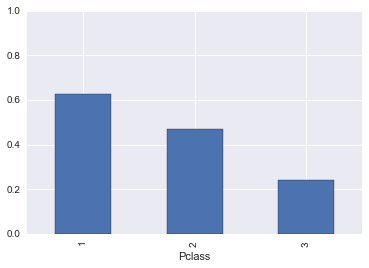

In [20]:
titanic.groupby('Pclass')['Survived'].mean().plot(kind='bar', ylim=[0,1])

In [21]:
stats.pearsonr(titanic['Pclass'], titanic['Survived'])[0] # Pearson's r

-0.33848103596101536

#### 3.2.2 Fare price

In this graph, the data has been binned to reduce visual clutter and make the graph easier to read. From the graph you can see a somewhat weak but existent positive correlation between fare price and survival rate; this is confirmed by a Pearson's r of 0.24. This makes intuitive sense as the ticket price could be viewed as a proxy for passenger class which, as we have already shown, is correlated with survival rate.

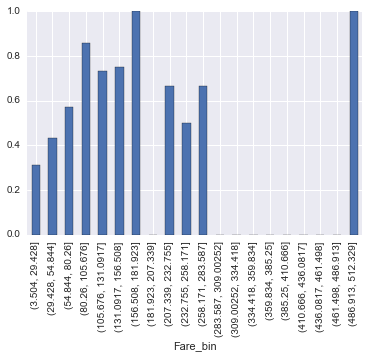

In [22]:
titanic['Fare_bin'] = pd.cut(titanic['Fare'], bins=20)
titanic.groupby('Fare_bin')['Survived'].mean().plot(kind='bar', ylim=[0,1])

In [23]:
stats.pearsonr(titanic['Fare'], titanic['Survived'])[0] # Pearson's r

0.24884432206584922

#### 3.2.3 Passenger Age

In this graph, the data has been binned to reduce visual clutter and make the graph easier to read. From the graph, there is no indication that a general and direct correlation between passenger age and survival rates exist; this is confirmed by a near zero Pearson's r coefficient of 0.067.

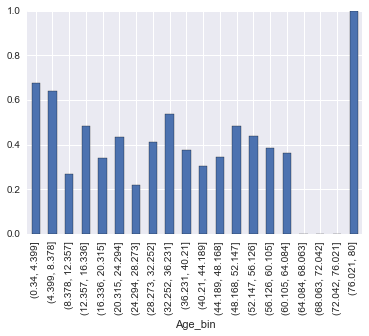

In [24]:
titanic['Age_bin'] = pd.cut(titanic['Age'], bins=20)
titanic.groupby('Age_bin')['Survived'].mean().plot(kind='bar', ylim=[0,1])

In [25]:
stats.pearsonr(titanic['Age'], titanic['Survived'])[0] # Pearson's r

-0.067484975685333945

#### 3.2.4 Passenger Sex

From the graph, there is a clear and strong correlation between the sex of a passenger and their survival rate; this is confirmed by a Pearson's r coefficient of 0.54.

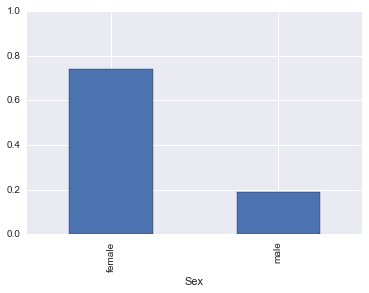

In [26]:
titanic.groupby('Sex')['Survived'].mean().plot(kind='bar', ylim=[0,1])

In [27]:
stats.pearsonr(titanic['Female'], titanic['Survived'])[0] # Pearson's r

0.54335138065775523

## Part 4: Conclusion

From the data exploration preformed in Part 3, class, fare, and sex were correlated with survival rates while age was not. Sex had the highest correlation with survival rates, followed by class and fare, respectively. It should also be noted that class and fare are proxies for each other since higher class tickets, in general, have a higher fare. If we were to build a prediction model for survivorship, it may be prudent to either choose one of these or to combine them into a single feature.

This analysis has focused on a single variable at a time, but it's worth keeping in mind that part of one variables correlation may be explained by another related variable. For instance, some of the correlation between passenger class and survival rate can be explained by the higher rate of females in the higher passenger classes, as shown below.

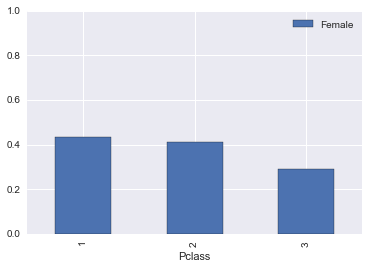

In [28]:
titanic[['Pclass', 'Female']].groupby('Pclass').mean().plot(kind='bar', ylim=[0,1])

A summary of the class and sex factors on survival rate are shown in the contingency table below. As expected from the analysis, first class females had the highest survival rate while third class males had the lowest.

In [29]:
titanic[['Pclass','Sex','Survived']].groupby(['Pclass', 'Sex']).mean()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

### Sources:
[1] http://www.encyclopedia-titanica.org/titanic-first-class-passengers/  "Encyclopedia Titanica"

[2] https://en.wikipedia.org/wiki/Anscombe%27s_quartet "Anscombe's quartet"